Importing necessary libraries

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

Neural Network

In [ ]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        #architecture
        self.network = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, z):
        return self.network(z)

Loss function

In [ ]:
def physics_loss(model, z, x0, v0, xi):
    z.requires_grad = True
    x = model(z)

    # First derivative
    dx_dz = torch.autograd.grad(x, z, grad_outputs=torch.ones_like(x),
                                 create_graph=True, retain_graph=True)[0]

    # Second derivative
    d2x_dz2 = torch.autograd.grad(dx_dz, z, grad_outputs=torch.ones_like(dx_dz),
                                  create_graph=True, retain_graph=True)[0]

    # Physics-informed loss
    physics_loss = torch.mean((d2x_dz2 + 2*xi*dx_dz + x)**2)

    # Initial condition losses
    ic_loss_x = (x[0] - x0)**2
    ic_loss_v = (dx_dz[0] - v0)**2

    return physics_loss + ic_loss_x + ic_loss_v


Training

In [ ]:
def train_pinn(xi=0.2):
    # Prepare for training
    z_max = 40
    z = torch.linspace(0, z_max, 200).unsqueeze(1).float()

    # Initialize model and optimizer
    model = PINN()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Training
    for _ in range(5000):
        optimizer.zero_grad()

        loss = physics_loss(model, z, x0=0.7, v0=1.2, xi=xi)

        # Backpropagation
        loss.backward()
        optimizer.step()

    return model, z

Test

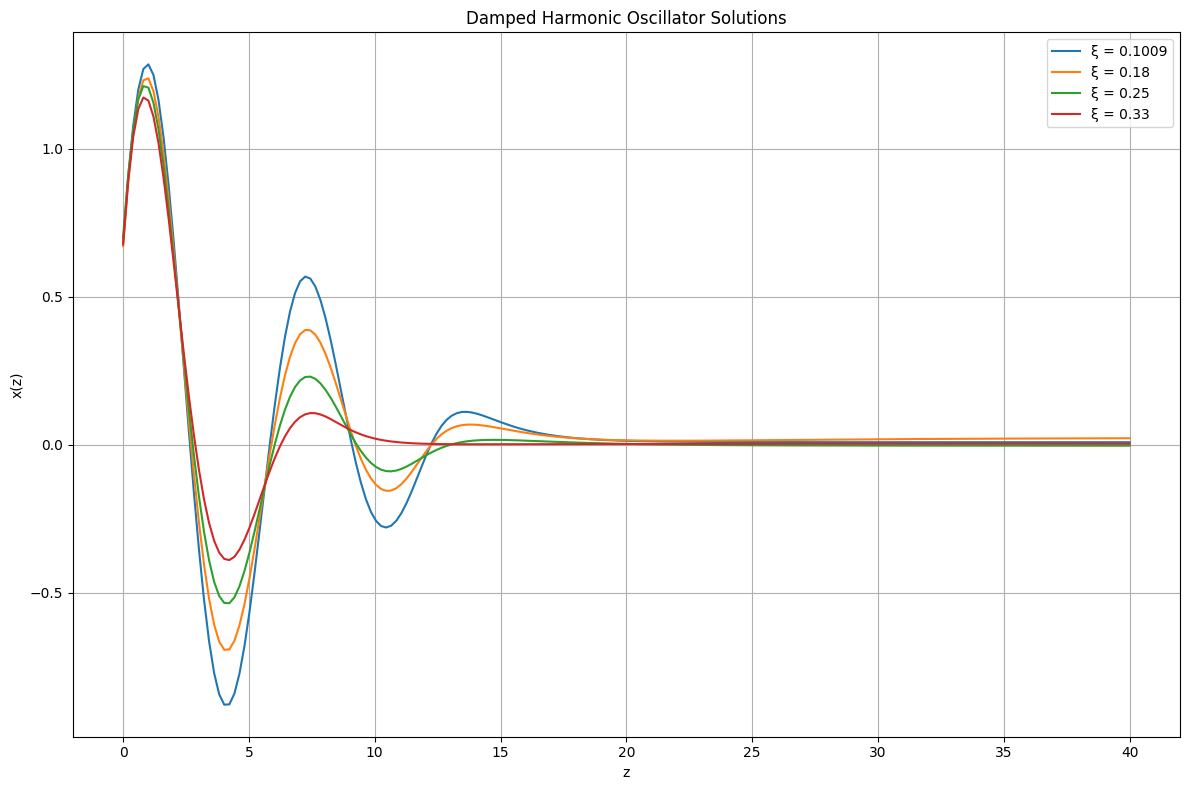

In [ ]:
plt.figure(figsize=(12, 8))
damping_ratios = [0.1009, 0.18, 0.25, 0.33]

for xi in damping_ratios:
    model, z = train_pinn(xi)

    # Predict solution
    with torch.no_grad():
      x_pred = model(z).detach().numpy()


    # Plot solution
    plt.plot(z.detach().numpy(), x_pred, label=f'ξ = {xi}')

plt.title('Damped Harmonic Oscillator Solutions')
plt.xlabel('z')
plt.ylabel('x(z)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()